### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

### Getting to know the data

In [2]:
data = np.load('inputs/proyecto_training_data.npy')

In [3]:
print(data.shape)
n_train = int(np.ceil(data.shape[0]*0.8))

(1460, 6)


In [5]:
train, test = data[:n_train, :], data[n_train:, :] 
assert (train.shape[0] + test.shape[0]) == data.shape[0]

In [6]:
data

array([[2.08500e+05, 7.00000e+00, 8.56000e+02, 8.00000e+00, 2.00300e+03,
        6.50000e+01],
       [1.81500e+05, 6.00000e+00, 1.26200e+03, 6.00000e+00, 1.97600e+03,
        8.00000e+01],
       [2.23500e+05, 7.00000e+00, 9.20000e+02, 6.00000e+00, 2.00100e+03,
        6.80000e+01],
       ...,
       [2.66500e+05, 7.00000e+00, 1.18800e+03, 9.00000e+00, 1.94100e+03,
        6.60000e+01],
       [1.42125e+05, 5.00000e+00, 1.07800e+03, 5.00000e+00, 1.95000e+03,
        6.80000e+01],
       [1.47500e+05, 5.00000e+00, 1.25600e+03, 6.00000e+00, 1.96500e+03,
        7.50000e+01]])

In [7]:
ds_train = pd.DataFrame(train, columns = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
ds_train.head()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0


In [8]:
stats = ds_train.describe().loc[['mean', 'max', 'min', 'std']]

In [10]:
stats = stats.append((ds_train.max() - ds_train.min()).rename('range'))
stats

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
mean,180590.277397,6.101027,1156.323630,6.485445,1971.451199,69.946985
max,755000.000000,10.000000,3228.000000,14.000000,2010.000000,313.000000
min,34900.000000,1.000000,334.000000,2.000000,1875.000000,21.000000
std,78815.697902,1.378025,373.780374,1.609141,29.951707,23.478161
range,720100.000000,9.000000,2894.000000,12.000000,135.000000,292.000000
range,720100.000000,9.000000,2894.000000,12.000000,135.000000,292.000000


### Visualizing the data

In [20]:
#for col in ds_train.columns[0:]:
    #sns.distplot(a = ds_train[col], kde = 'True') #distplot is deprecated
    #sns.displot(data = ds_train, x = col, kde = True)
    #plt.title('{} distribution'.format(col))
    #plt.show()

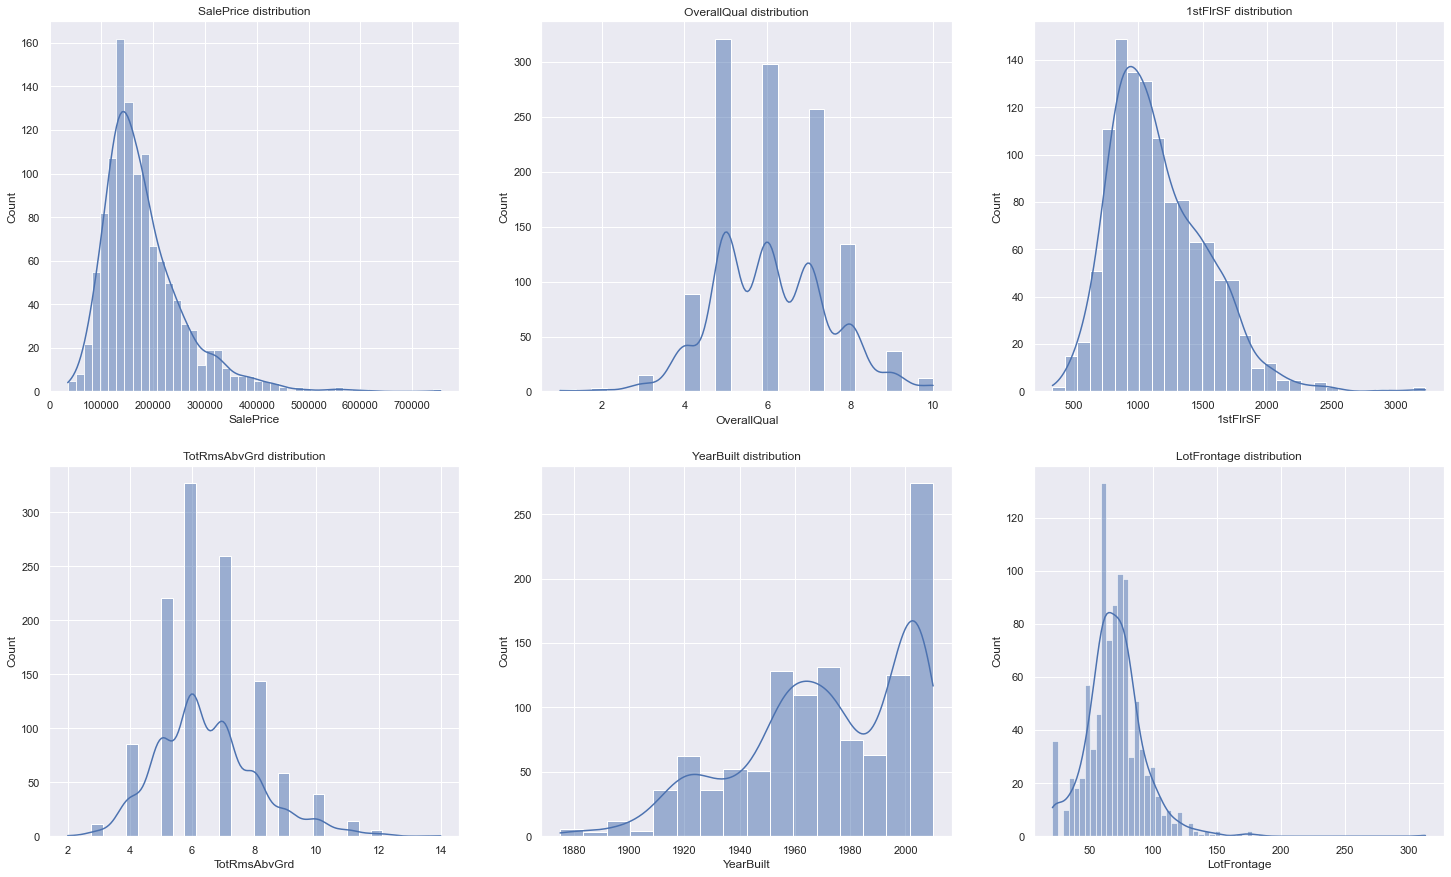

In [18]:
i = 2
j = 3
cols = list(ds_train.columns)
sns.set(rc={'figure.figsize': (25, 15)})
fig, ax = plt.subplots(i, j)

for f in range(0, i):
    for c in range(0, j):
        #sns.displot(data = ds_train, x = cols[c + (f * 3)], kind = "hist", kde = True, ax = ax[f, c])
        #sns.distplot(ds_train.iloc[:, c + (f * 3)], kde = True, ax = ax[f, c])
        ax[f, c].set_title('{} distribution'.format(cols[c + (f * 3)]))
        sns.histplot(data = ds_train, x = cols[c + (f * 3)], kde = True, ax = ax[f, c])
    
plt.show()

#### Correlation Analysis

In [21]:
response = 'SalePrice'
regressors = ds_train.columns[1:]

In [22]:
corr_values = ds_train.corr()[response].iloc[1:].round(4).sort_values(ascending = False)
corr_values

OverallQual     0.7940
1stFlrSF        0.6163
TotRmsAbvGrd    0.5647
YearBuilt       0.5342
LotFrontage     0.3633
Name: SalePrice, dtype: float64

In [24]:
#for x in regressors:
    #plt.scatter(x = ds_train[x], y = ds_train[response])
    #plt.title('{} vs {} \n Corr Coef: {}'.format(x, response, corr_values[x]))
    #plt.xlabel(x)
    #plt.ylabel(response)
    #plt.show()

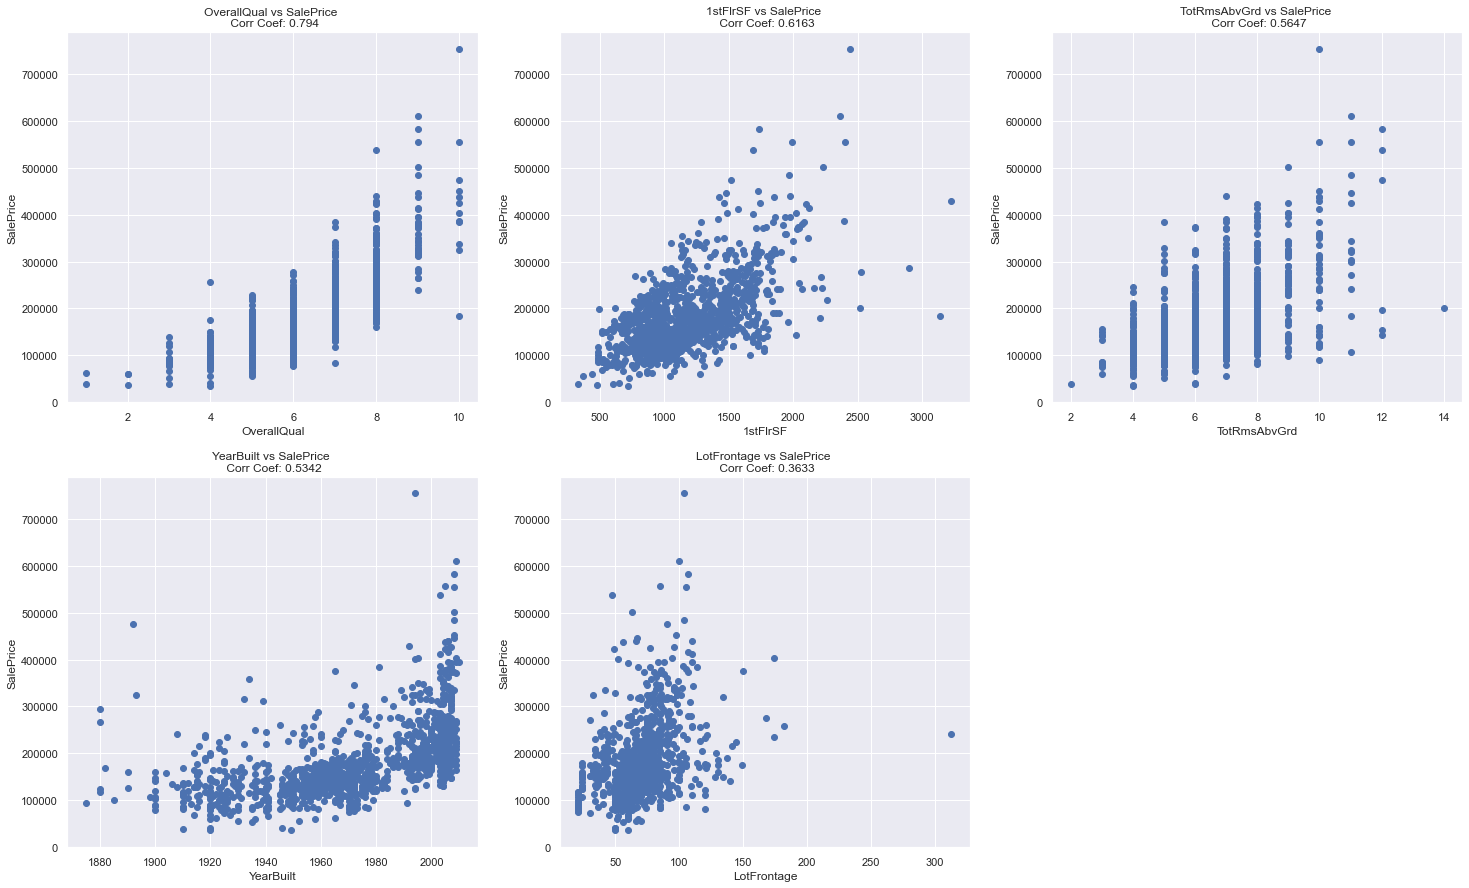

In [25]:
fig  = plt.figure()

for i in range(0, len(regressors)):
    ax = fig.add_subplot(2, 3, i+1)
    x = regressors[i]
    ax.scatter(x = ds_train[x], y = ds_train[response])
    ax.set_title('{} vs {} \n Corr Coef: {}'.format(x, response, corr_values[x]))
    ax.set(xlabel = x, ylabel = response)

plt.show()

In [26]:
#select top 2 regressors based on highest correlation coefficient
regressors = list(corr_values.index[0:2])
regressors

['OverallQual', '1stFlrSF']

### Manual Model

In [27]:
def getError(Y, yhat):
    return (1/2) * np.mean(np.power((Y - yhat), 2))

In [93]:
def trainModel(X, Y, epochs = 100, print_error_every = 10, lr = 0.001):
    #initializing data
    observations = np.hstack((X, np.ones_like(X)))
    errors = []
    model_params = dict()
    parameters = np.zeros((2, 1)) #np.zeros((2,))

    for i in range(1, epochs + 1):
        #estimating values
        yhat = np.matmul(observations, parameters)
        
        #calculating errors
        error = getError(Y, yhat)
        errors.append(error)
        
        #calculating gradients
        gradients = np.mean(np.hstack(((yhat - Y),(yhat - Y))) * observations, axis = 0)[:, np.newaxis]
        parameters = parameters - (lr * gradients)
        model_params[i] = parameters
        
        if i % print_error_every == 0:
            print("Epoch {}/{}, error value: {}".format(i, epochs, error))
        
    return model_params, errors

In [89]:
def plotError(errors):
    plt.plot(range(0,len(errors)), errors)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Losses")
    plt.show()
    return

In [122]:
sns.set(rc={"figure.figsize": (8, 4)})

def visualizeModel(X, Y, model_params, n = 25):
    for i in range(0, len(model_params)):
        if i % n == 0:
            plt.scatter(x = X, y = Y)
            yhat = np.matmul(np.hstack((X, np.ones_like(X))), model_params[i+1])
            plt.plot(X, yhat, color = 'black')
            plt.show()
    return

### Train Variables

#### OverallQual

In [118]:
X1 = ds_train[regressors[0]].values[:, np.newaxis]
Y = ds_train[response].values[:, np.newaxis]

In [119]:
#lm_m1, errors_m1 = trainModel(X1, Y, epochs = 1000,  print_error_every = 100, lr = 0.001)
lm_m1, errors_m1 = trainModel(X1, Y, epochs = 1000,  print_error_every = 100, lr = 0.01)

Epoch 100/1000, error value: 1372583361.4180565
Epoch 200/1000, error value: 1352189866.2232428
Epoch 300/1000, error value: 1333639327.1745892
Epoch 400/1000, error value: 1316765196.6879644
Epoch 500/1000, error value: 1301415978.0516312
Epoch 600/1000, error value: 1287453865.281867
Epoch 700/1000, error value: 1274753505.894571
Epoch 800/1000, error value: 1263200875.4849553
Epoch 900/1000, error value: 1252692254.0112436
Epoch 1000/1000, error value: 1243133294.5914187


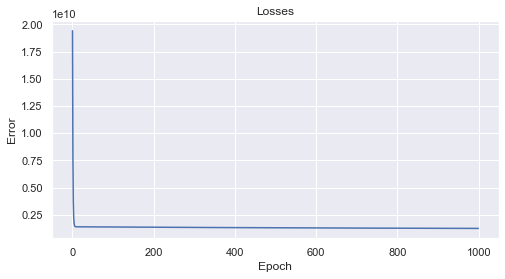

In [120]:
plotError(errors_m1)

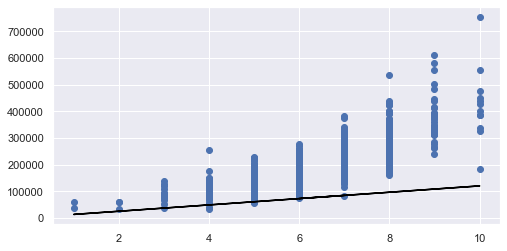

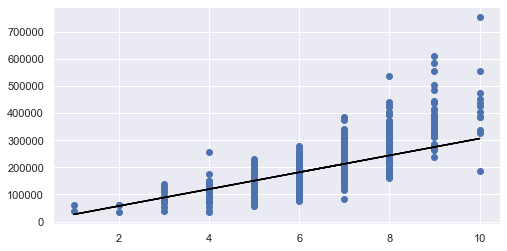

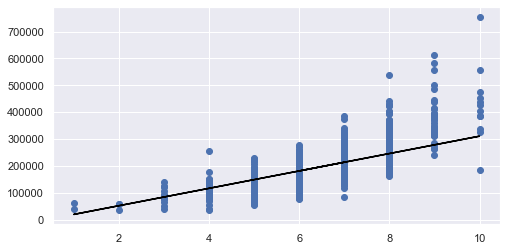

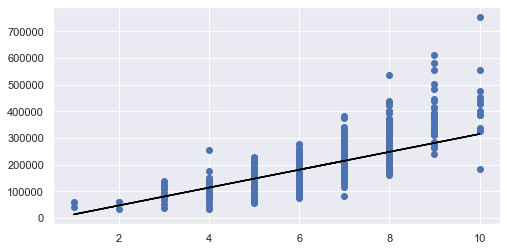

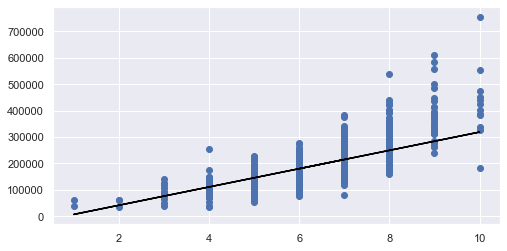

In [123]:
visualizeModel(X1, Y, lm_m1, n = 200)

### 1stFlrSf

In [124]:
X2 = ds_train[regressors[1]].values[:, np.newaxis]

In [125]:
lm_m2, errors_m2 = trainModel(X2, Y, epochs = 100,  print_error_every = 10, lr = 0.0000001)

Epoch 10/100, error value: 2951079963.607947
Epoch 20/100, error value: 2008339398.4337852
Epoch 30/100, error value: 1969740863.8804588
Epoch 40/100, error value: 1968160520.3053045
Epoch 50/100, error value: 1968095808.58542
Epoch 60/100, error value: 1968093151.219357
Epoch 70/100, error value: 1968093034.538102
Epoch 80/100, error value: 1968093021.8798368
Epoch 90/100, error value: 1968093013.4805748
Epoch 100/100, error value: 1968093005.2556908


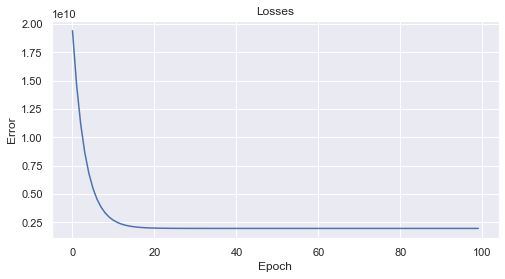

In [126]:
plotError(errors_m2)

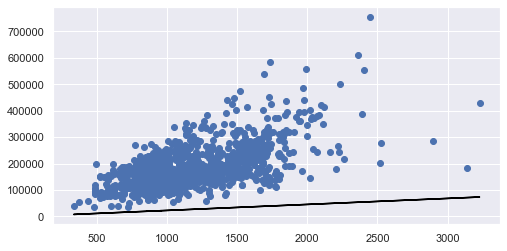

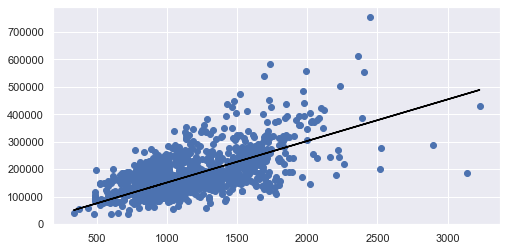

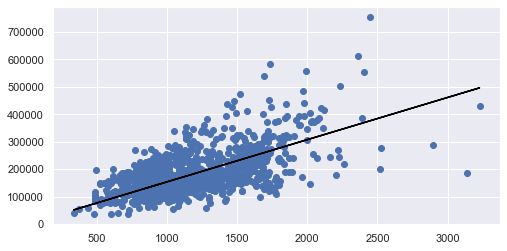

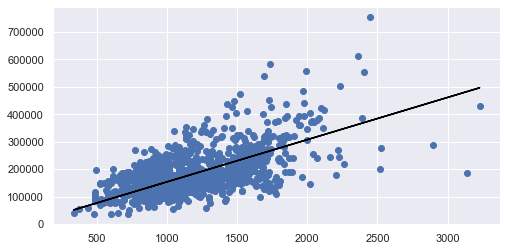

In [127]:
visualizeModel(X2, Y, lm_m2, n = 25)

### Second Model with Scikit-Learn

In [128]:
Xs1 = np.hstack((X1, np.ones_like(X1)))
Xs2 = np.hstack((X2, np.ones_like(X2)))

In [129]:
lm_s1 = LinearRegression().fit(Xs1, Y)
lm_s2 = LinearRegression().fit(Xs2, Y)

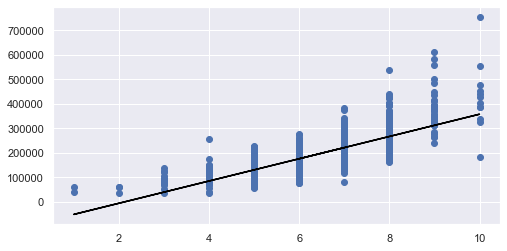

In [131]:
#plotting lm_s1
plt.scatter(x = X1, y = Y)
yh = lm_s1.predict(Xs1)
plt.plot(X1, yh, color = 'black')
plt.show()

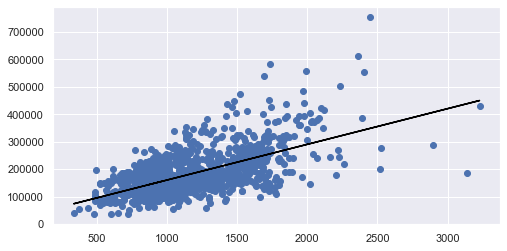

In [132]:
#plotting lm_s2
plt.scatter(x = X2, y = Y)
yh = lm_s2.predict(Xs2)
plt.plot(X2, yh, color = 'black')
plt.show()

### Estimating predictions

In [133]:
def predict(lm1, lm2, X):
    yhat_m = np.matmul(np.hstack((X, np.ones_like(X))), lm1[len(lm1)]) #manual
    yhat_s = lm2.predict(np.hstack((X, np.ones_like(X)))) #sklearn
    yhat_c = np.mean(np.hstack((yhat_m, yhat_s)), axis = 1) #mean

    return yhat_m, yhat_s, yhat_c

In [134]:
def testModels(lm1, lm2, lms1, lms2, test):
    #Overallqual results
    m1, s1, c1 = predict(lm1, lms1, test[:, 1][:, np.newaxis])
    em1 = getError(test[:, 1], m1)
    es1 = getError(test[:, 1], s1)
    ec1 = getError(test[:, 1], c1)
    
    #1stFlrSF results
    m2, s2, c2 = predict(lm2, lms2, test[:, 2][:, np.newaxis])
    em2 = getError(test[:, 1], m2)
    es2 = getError(test[:, 1], s2)
    ec2 = getError(test[:, 1], c2)
    
    ##Graphs
    labels = ['OverallQual', '1stFlrSF']
    m_errors = [em1, em2]
    s_errors = [es1, es2]
    c_errors = [ec1, ec2]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, m_errors, width, label = labels[0])
    rects2 = ax.bar(x + width/2, s_errors, width, label = labels[1])
    #rects2 = ax.bar(x + width, c_errors, width, label='Women')

        
    return

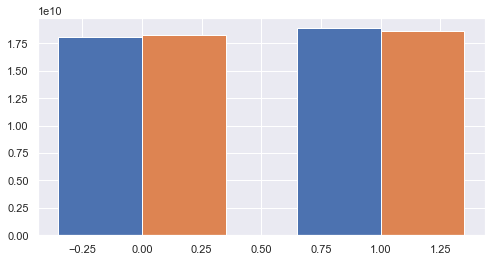

In [135]:
testModels(lm_m1, lm_m2, lm_s1, lm_s2, test)

In [ ]:
#Overallqual results
#m1, s1, c1 = predict(lm_m1, lm_s1, test[:, 1])

#1stFlrSF results
#m2, s2, c2 = predict(lm_m2, lm_s2, test[:, 2])